In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [2]:
%%time
common_test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]

additional_test_station_id = [200, 228, 432, 435, 456]

test_station_id = common_test_station_id + additional_test_station_id


train_station_id = [113, 115, 116, 118, 126, 150, 152, 223, 
                    239, 305, 308, 401, 411, 454, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis, interpol_freq=20)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_pressure', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY], data[MmxColumns.ID_ROAD_TEMPERATURE]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 39s, sys: 12.1 s, total: 1min 51s
Wall time: 1min 51s


## Feature selection

In [3]:
from preprocessing import create_feature_df
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from functools import partial

In [4]:
point = pd.Timestamp(2015, 6, 1)

target = 'data_pressure'

params_df = {}
params_df['target'] = target
params_df['variables'] = ['data_t_air', 'data_t_road', 'data_t_underroad', 
                          'data_pressure', 'data_dampness']
params_df['interpol_freq'] = 20
params_df['lag_list'] = (1, 2, 3, 4, 5, 6, 7, 8)
params_df['diff_list'] = ((1, 2), (2, 3), (3, 4), (4, 5), (5, 6))
params_df['coordinates'] = True
params_df['solar_angles'] = True
params_df['road_id'] = False
params_df['day_of_year'] = True
params_df['month'] = False
params_df['hour'] = True
params_df['post_process'] = False

min_value = 675
max_value = 825
train_filtered = copy(train[(train[target] < max_value) & (train[target] > min_value)])
df_train = create_feature_df(train_filtered[train_filtered['date_time_utc'] < point], **params_df)
df_valid = create_feature_df(train_filtered[train_filtered['date_time_utc'] >= point], **params_df)
df_test = create_feature_df(test, **params_df)

In [5]:
main_cols = ('data_t_road', 'data_t_air', 'data_t_underroad', 'data_pressure', 'data_humidity')
features = [col for col in df_train if col.startswith('data_')]
features = [col for col in features if col not in (main_cols)]
target = [col for col in df_train if col.startswith('target_')][0]

X_train = np.array(df_train[features].values)
y_train = np.array(df_train[target].values)

X_valid = np.array(df_valid[features].values)
y_valid = np.array(df_valid[target].values)

X_test = np.array(df_test[features].values)
y_test = np.array(df_test[target].values)

lgb_train = lgb.Dataset(X_train, y_train, feature_name=features)
lgb_val = lgb.Dataset(X_valid, y_valid, reference=lgb_train, feature_name=features)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, feature_name=features)

## Train model

In [6]:
df = df_valid
baseline_mae = mean_absolute_error(df.data_pressure_lag_20, df.target_pressure)
baseline_mse = mean_squared_error(df.data_pressure_lag_20, df.target_pressure)

print('MAE: {0: .3f} \nMSE: {1: .3f}'.format(baseline_mae, baseline_mse))

MAE:  0.093 
MSE:  0.111


In [7]:
#	 0.0846651	valid's l1: 0.0865841

In [8]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l1',
    'num_leaves': 25,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 4,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=(lgb_train, lgb_val, lgb_test),
                valid_names=('train', 'valid', 'test'),
                verbose_eval=200,)

[200]	train's l1: 0.100207	valid's l1: 0.0901547	test's l1: 63.0414
[400]	train's l1: 0.0958368	valid's l1: 0.0885764	test's l1: 63.0429
[600]	train's l1: 0.0939462	valid's l1: 0.088178	test's l1: 63.0441
[800]	train's l1: 0.0926266	valid's l1: 0.0878715	test's l1: 63.0451
[1000]	train's l1: 0.091653	valid's l1: 0.0876703	test's l1: 63.0457
[1200]	train's l1: 0.0908377	valid's l1: 0.0874736	test's l1: 63.0461
[1400]	train's l1: 0.0901078	valid's l1: 0.0872602	test's l1: 63.0461
[1600]	train's l1: 0.0893072	valid's l1: 0.086979	test's l1: 63.046
[1800]	train's l1: 0.0886588	valid's l1: 0.0867999	test's l1: 63.0464
[2000]	train's l1: 0.0879667	valid's l1: 0.0864679	test's l1: 63.0462
[2200]	train's l1: 0.0875333	valid's l1: 0.0864576	test's l1: 63.0465
[2400]	train's l1: 0.0870339	valid's l1: 0.0863233	test's l1: 63.0466
[2600]	train's l1: 0.0866	valid's l1: 0.0862825	test's l1: 63.0466
[2800]	train's l1: 0.0861243	valid's l1: 0.0861443	test's l1: 63.0467
[3000]	train's l1: 0.0856025	val

In [9]:
z = list(zip(features, list(gbm.feature_importance())))
z.sort(key=lambda item: item[1], reverse=True)
z[:10]

[('data_pressure_diff_20_40', 9541),
 ('data_pressure_diff_40_60', 7303),
 ('data_pressure_diff_100_120', 6025),
 ('data_pressure_lag_20', 5753),
 ('data_pressure_diff_60_80', 4014),
 ('data_solar_altitude', 2876),
 ('data_pressure_lag_40', 2806),
 ('data_pressure_diff_80_100', 2738),
 ('data_dayofyear_cos', 2577),
 ('data_pressure_lag_60', 2365)]

## Save model

In [ ]:
import pickle

f = open('/mnt/HARD/MinMax94/models/anomaly_detection/detector_pressure.pickle','wb')                                                                                                                                                                                                                                                           
pickle.dump(gbm,f)                                                                                                                                                                                                                                                                        
f.close()

## Predict values

In [185]:
y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)

## Decision Function

In [186]:
threshold = 1.8
df_train['predict_pressure'] = y_train_pred
df_train['label_predict'] = np.abs(y_train - y_train_pred) > threshold
num_of_outliers = len(df_train[df_train['label_predict']])
percentage = num_of_outliers / len(df_train)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_train)))

Ratio of anomalies is 0.00021% (244 out of 1189999)


In [192]:
df_train.groupby('station_id')['label_predict'].sum()

station_id
113       7.0
115      10.0
116       3.0
118       0.0
126      10.0
150       5.0
152       3.0
223      22.0
239      14.0
305       7.0
308       8.0
401      10.0
411      19.0
454      23.0
593       8.0
628       7.0
1831     27.0
1899      6.0
1911      6.0
1921      6.0
4007      5.0
20717     6.0
20743    10.0
20754     1.0
20755     0.0
20761     4.0
20916     7.0
20921    10.0
Name: label_predict, dtype: float64

In [193]:
threshold = 1.8
df_test['predict_pressure'] = y_pred
df_test['label_predict'] = np.abs(y_test - y_pred) > threshold
num_of_outliers = len(df_test[df_test['label_predict']])
percentage = num_of_outliers / len(df_test)
print("Ratio of anomalies is {0:.5f}% ({1} out of {2})".format(percentage, num_of_outliers, len(df_test)))

Ratio of anomalies is 0.01490% (20157 out of 1352394)


In [194]:
df_test.groupby('station_id')['label_predict'].sum()

station_id
114        32.0
117        22.0
119       265.0
200       456.0
228       232.0
302       607.0
303        21.0
307       181.0
393        86.0
432      1380.0
435      1140.0
442     12217.0
456      1744.0
503         9.0
504       873.0
511       289.0
516        33.0
1838      284.0
1896      286.0
Name: label_predict, dtype: float64

## Plot result

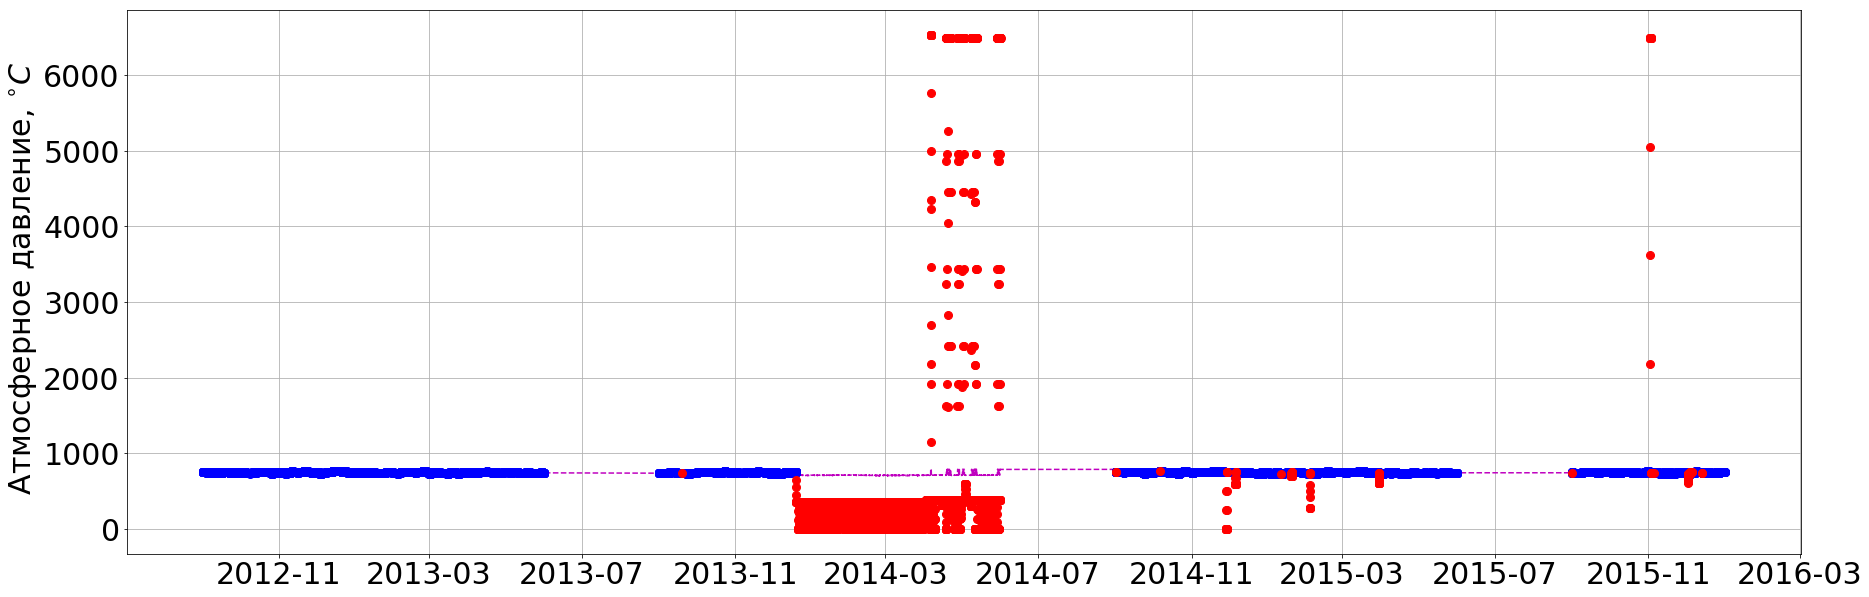

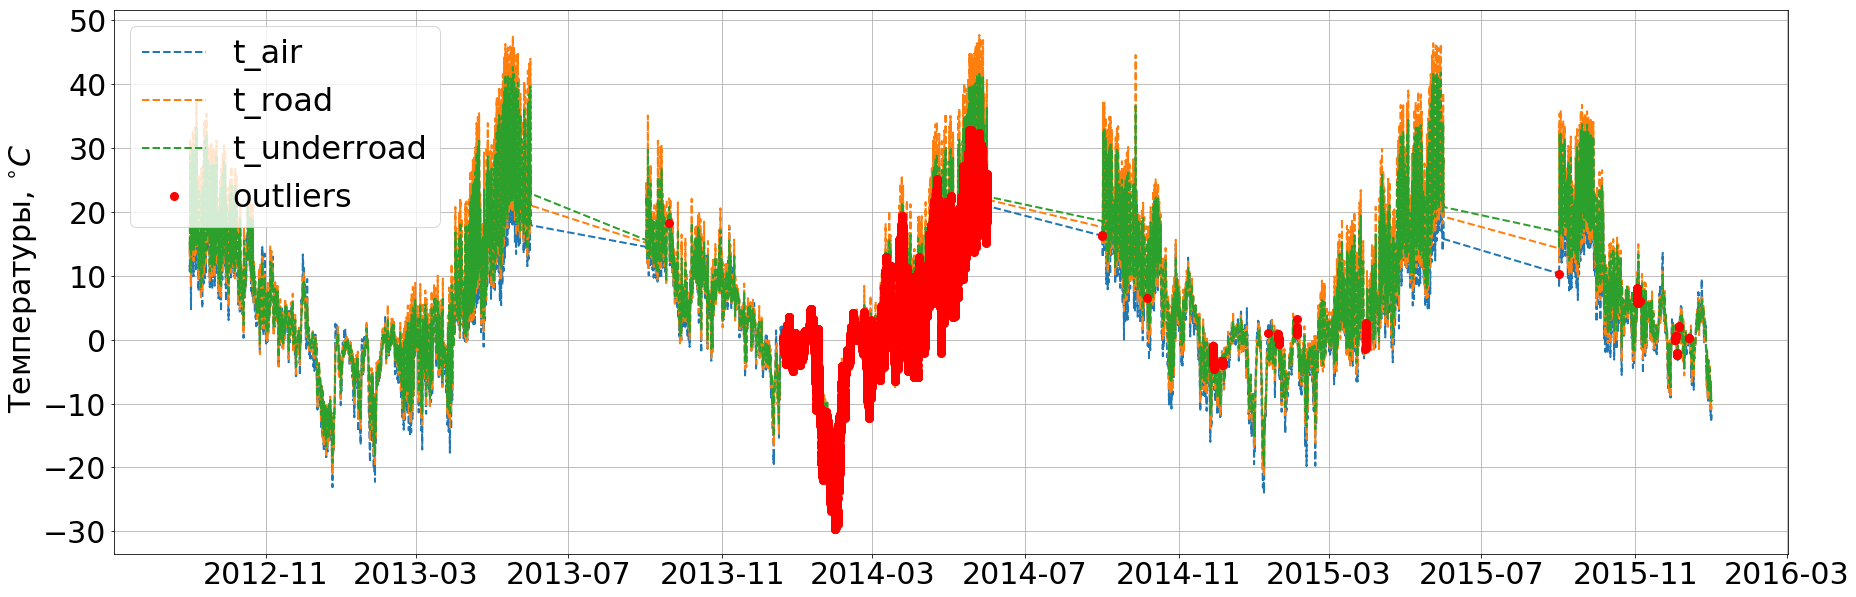

In [203]:
import matplotlib.pyplot as plt

#####-----------------------------STATION_ID-------------------------------#####
z = copy(df_test[df_test['station_id']==442].set_index('date_time_utc'))
#z = copy(df_train[df_train['station_id']==1838].set_index('date_time_utc'))

#####-----------------------------TIME_INTERVAL-------------------------------#####
start = pd.Timestamp(2012, 5, 1)
end = pd.Timestamp(2016, 1, 1)
to_plot = z[(z.index<=end) & (z.index>=start)]

#####-----------------------------PRESSURE-------------------------------#####
plt.figure(figsize=(30, 10))

plt.plot_date(to_plot.index, to_plot['predict_pressure'], 'm',
                      linestyle='--', marker='None', markersize=8, label='predicted pressure')

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_pressure'], 'b',
                      linestyle='none', marker='o', markersize=8, label='true pressure')
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_pressure'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
#plt.legend(fontsize=32)
#plt.ylim((720, 780))
plt.ylabel(r' Атмосферное давление, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)


#####-----------------------------TEMPERATURE-------------------------------#####
plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot.index, to_plot['data_t_air'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_air')
        
        plt.plot_date(to_plot.index, to_plot['data_t_road'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_road')
        
        plt.plot_date(to_plot.index, to_plot['data_t_underroad'],
                      linestyle='--', linewidth=2, marker='None', markersize=8, label='t_underroad')
        
    else:        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['data_t_air'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температуры, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)

plt.show()